In [6]:
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization, MaxPooling2D,MaxPool3D
from keras.layers import Dropout, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

# Data Loading

In [7]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.7
windowSize = 25

In [8]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'data/Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'data/Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'data/PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'data/PaviaU_gt.mat'))['paviaU_gt']

    return data, labels

In [9]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [10]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [11]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [12]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [13]:
X, y = loadData(dataset)

X.shape, y.shape

((145, 145, 200), (145, 145))

In [14]:
K = X.shape[2]

In [15]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(145, 145, 30)

In [16]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((10249, 25, 25, 30), (10249,))

In [17]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3074, 25, 25, 30), (7175, 25, 25, 30), (3074,), (7175,))

# Model and Training

In [18]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(3074, 25, 25, 30, 1)

In [19]:
ytrain = keras.utils.to_categorical(ytrain)
ytrain.shape

(3074, 16)

In [20]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [21]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
encoded = MaxPool3D((2, 2, 2), padding='same')(conv_layer3)
#print(conv_layer3._keras_shape)
conv3d_shape = encoded.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(encoded)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv_layer4)

flatten_layer = Flatten()(decoded)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

In [22]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 25, 30, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 23, 23, 24, 8)     512       
                                                                 
 conv3d_1 (Conv3D)           (None, 21, 21, 20, 16)    5776      
                                                                 
 conv3d_2 (Conv3D)           (None, 19, 19, 18, 32)    13856     
                                                                 
 max_pooling3d (MaxPooling3  (None, 10, 10, 9, 32)     0         
 D)                                                              
                                                                 
 reshape (Reshape)           (None, 10, 10, 288)       0         
                                                             

In [24]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [28]:
# compiling the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [29]:
# checkpoint
filepath = "info/best-model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [30]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 2.6098 - accuracy: 0.1539

13/13 [==============================] - 15s 202ms/step - loss: 2.6098 - accuracy: 0.1539
Epoch 2/100
12/13 [==========================>...] - ETA: 0s - loss: 2.4278 - accuracy: 0.2012

13/13 [==============================] - 2s 176ms/step - loss: 2.4282 - accuracy: 0.2010
Epoch 3/100
12/13 [==========================>...] - ETA: 0s - loss: 2.4088 - accuracy: 0.1973

13/13 [==============================] - 2s 171ms/step - loss: 2.4082 - accuracy: 0.1975
Epoch 4/100
12/13 [==========================>...] - ETA: 0s - loss: 2.3695 - accuracy: 0.2256

13/13 [==============================] - 2s 172ms/step - loss: 2.3697 - accuracy: 0.2254
Epoch 5/100
12/13 [==========================>...] - ETA: 0s - loss: 2.3266 - accuracy: 0.2236

13/13 [==============================] - 2s 171ms/step - loss: 2.3263 - accuracy: 0.2238
Epoch 6/100
12/13 [==========================>...] - ETA: 0s - loss: 2.1985 - accuracy: 0.2357

13/13 [==============================] - 2s 172ms/step - loss: 2.1977 - accuracy: 0.2362
Epoch 7/100
12/13 [==========================>...] - ETA: 0s - loss: 2.1430 - accuracy: 0.2399

13/13 [==============================] - 2s 176ms/step - loss: 2.1425 - accuracy: 0.2401
Epoch 8/100
12/13 [==========================>...] - ETA: 0s - loss: 2.0471 - accuracy: 0.2549

13/13 [==============================] - 2s 176ms/step - loss: 2.0473 - accuracy: 0.2547
Epoch 9/100
12/13 [==========================>...] - ETA: 0s - loss: 1.9651 - accuracy: 0.2930

13/13 [==============================] - 2s 175ms/step - loss: 1.9644 - accuracy: 0.2931
Epoch 10/100
12/13 [==========================>...] - ETA: 0s - loss: 1.9052 - accuracy: 0.3340

13/13 [==============================] - 2s 175ms/step - loss: 1.9050 - accuracy: 0.3341
Epoch 11/100
12/13 [==========================>...] - ETA: 0s - loss: 1.8086 - accuracy: 0.3766

13/13 [==============================] - 2s 176ms/step - loss: 1.8083 - accuracy: 0.3767
Epoch 12/100
12/13 [==========================>...] - ETA: 0s - loss: 1.7075 - accuracy: 0.4189

13/13 [==============================] - 2s 178ms/step - loss: 1.7073 - accuracy: 0.4190
Epoch 13/100
12/13 [==========================>...] - ETA: 0s - loss: 1.6214 - accuracy: 0.4440

13/13 [==============================] - 2s 181ms/step - loss: 1.6214 - accuracy: 0.4440
Epoch 14/100
12/13 [==========================>...] - ETA: 0s - loss: 1.4883 - accuracy: 0.5046

13/13 [==============================] - 2s 179ms/step - loss: 1.4881 - accuracy: 0.5049
Epoch 15/100
12/13 [==========================>...] - ETA: 0s - loss: 1.3627 - accuracy: 0.5495

13/13 [==============================] - 2s 179ms/step - loss: 1.3619 - accuracy: 0.5498
Epoch 16/100
12/13 [==========================>...] - ETA: 0s - loss: 1.1871 - accuracy: 0.6042

13/13 [==============================] - 2s 180ms/step - loss: 1.1867 - accuracy: 0.6044
Epoch 17/100
12/13 [==========================>...] - ETA: 0s - loss: 1.0946 - accuracy: 0.6370

13/13 [==============================] - 2s 181ms/step - loss: 1.0941 - accuracy: 0.6373
Epoch 18/100
12/13 [==========================>...] - ETA: 0s - loss: 1.0253 - accuracy: 0.6611

13/13 [==============================] - 2s 184ms/step - loss: 1.0250 - accuracy: 0.6614
Epoch 19/100
12/13 [==========================>...] - ETA: 0s - loss: 0.8632 - accuracy: 0.7266

13/13 [==============================] - 2s 183ms/step - loss: 0.8630 - accuracy: 0.7264
Epoch 20/100
12/13 [==========================>...] - ETA: 0s - loss: 0.8686 - accuracy: 0.7207

13/13 [==============================] - 2s 183ms/step - loss: 0.8681 - accuracy: 0.7209
Epoch 21/100
12/13 [==========================>...] - ETA: 0s - loss: 0.7327 - accuracy: 0.7682

13/13 [==============================] - 2s 184ms/step - loss: 0.7337 - accuracy: 0.7677
Epoch 22/100
12/13 [==========================>...] - ETA: 0s - loss: 0.9987 - accuracy: 0.6650

13/13 [==============================] - 2s 184ms/step - loss: 0.9984 - accuracy: 0.6653
Epoch 23/100
12/13 [==========================>...] - ETA: 0s - loss: 0.8324 - accuracy: 0.7305

13/13 [==============================] - 2s 186ms/step - loss: 0.8323 - accuracy: 0.7306
Epoch 24/100
12/13 [==========================>...] - ETA: 0s - loss: 0.6781 - accuracy: 0.7917

13/13 [==============================] - 2s 185ms/step - loss: 0.6777 - accuracy: 0.7918
Epoch 25/100
12/13 [==========================>...] - ETA: 0s - loss: 0.5835 - accuracy: 0.8249

13/13 [==============================] - 2s 185ms/step - loss: 0.5833 - accuracy: 0.8250
Epoch 26/100
12/13 [==========================>...] - ETA: 0s - loss: 0.5126 - accuracy: 0.8490

13/13 [==============================] - 2s 187ms/step - loss: 0.5123 - accuracy: 0.8491
Epoch 27/100
12/13 [==========================>...] - ETA: 0s - loss: 0.4729 - accuracy: 0.8581

13/13 [==============================] - 2s 186ms/step - loss: 0.4731 - accuracy: 0.8578
Epoch 28/100
12/13 [==========================>...] - ETA: 0s - loss: 0.5535 - accuracy: 0.8262

13/13 [==============================] - 2s 190ms/step - loss: 0.5541 - accuracy: 0.8260
Epoch 29/100
12/13 [==========================>...] - ETA: 0s - loss: 0.8305 - accuracy: 0.7438

13/13 [==============================] - 2s 188ms/step - loss: 0.8300 - accuracy: 0.7440
Epoch 30/100
12/13 [==========================>...] - ETA: 0s - loss: 0.5390 - accuracy: 0.8340

13/13 [==============================] - 2s 189ms/step - loss: 0.5387 - accuracy: 0.8341
Epoch 31/100
12/13 [==========================>...] - ETA: 0s - loss: 0.4399 - accuracy: 0.8636

13/13 [==============================] - 2s 187ms/step - loss: 0.4396 - accuracy: 0.8637
Epoch 32/100
12/13 [==========================>...] - ETA: 0s - loss: 0.3743 - accuracy: 0.8883

13/13 [==============================] - 2s 188ms/step - loss: 0.3741 - accuracy: 0.8884
Epoch 33/100
12/13 [==========================>...] - ETA: 0s - loss: 0.3277 - accuracy: 0.9059

13/13 [==============================] - 2s 188ms/step - loss: 0.3275 - accuracy: 0.9060
Epoch 34/100
12/13 [==========================>...] - ETA: 0s - loss: 0.2961 - accuracy: 0.9115

13/13 [==============================] - 2s 187ms/step - loss: 0.2960 - accuracy: 0.9115
Epoch 35/100
12/13 [==========================>...] - ETA: 0s - loss: 0.2915 - accuracy: 0.9170

13/13 [==============================] - 2s 185ms/step - loss: 0.2913 - accuracy: 0.9170
Epoch 36/100
12/13 [==========================>...] - ETA: 0s - loss: 0.2461 - accuracy: 0.9229

13/13 [==============================] - 2s 184ms/step - loss: 0.2460 - accuracy: 0.9229
Epoch 37/100
12/13 [==========================>...] - ETA: 0s - loss: 0.2213 - accuracy: 0.9287

13/13 [==============================] - 2s 185ms/step - loss: 0.2211 - accuracy: 0.9288
Epoch 38/100
12/13 [==========================>...] - ETA: 0s - loss: 0.2052 - accuracy: 0.9326

13/13 [==============================] - 2s 186ms/step - loss: 0.2051 - accuracy: 0.9327
Epoch 39/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1701 - accuracy: 0.9518

13/13 [==============================] - 2s 185ms/step - loss: 0.1701 - accuracy: 0.9519
Epoch 40/100
12/13 [==========================>...] - ETA: 0s - loss: 0.2167 - accuracy: 0.9355

13/13 [==============================] - 2s 183ms/step - loss: 0.2165 - accuracy: 0.9356
Epoch 41/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1659 - accuracy: 0.9486

13/13 [==============================] - 2s 182ms/step - loss: 0.1658 - accuracy: 0.9486
Epoch 42/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1479 - accuracy: 0.9583

13/13 [==============================] - 2s 187ms/step - loss: 0.1478 - accuracy: 0.9584
Epoch 43/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1221 - accuracy: 0.9629

13/13 [==============================] - 2s 186ms/step - loss: 0.1220 - accuracy: 0.9629
Epoch 44/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1117 - accuracy: 0.9727

13/13 [==============================] - 2s 184ms/step - loss: 0.1118 - accuracy: 0.9727
Epoch 45/100
12/13 [==========================>...] - ETA: 0s - loss: 0.3256 - accuracy: 0.8968

13/13 [==============================] - 2s 181ms/step - loss: 0.3253 - accuracy: 0.8969
Epoch 46/100
12/13 [==========================>...] - ETA: 0s - loss: 0.2047 - accuracy: 0.9378

13/13 [==============================] - 2s 182ms/step - loss: 0.2058 - accuracy: 0.9375
Epoch 47/100
12/13 [==========================>...] - ETA: 0s - loss: 0.3871 - accuracy: 0.8864

13/13 [==============================] - 2s 182ms/step - loss: 0.3874 - accuracy: 0.8861
Epoch 48/100
12/13 [==========================>...] - ETA: 0s - loss: 0.3744 - accuracy: 0.8835

13/13 [==============================] - 2s 183ms/step - loss: 0.3746 - accuracy: 0.8832
Epoch 49/100
12/13 [==========================>...] - ETA: 0s - loss: 0.3349 - accuracy: 0.8945

13/13 [==============================] - 2s 183ms/step - loss: 0.3347 - accuracy: 0.8946
Epoch 50/100
12/13 [==========================>...] - ETA: 0s - loss: 0.2068 - accuracy: 0.9395

13/13 [==============================] - 2s 182ms/step - loss: 0.2068 - accuracy: 0.9395
Epoch 51/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1864 - accuracy: 0.9437

13/13 [==============================] - 2s 182ms/step - loss: 0.1863 - accuracy: 0.9437
Epoch 52/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1418 - accuracy: 0.9590

13/13 [==============================] - 2s 182ms/step - loss: 0.1417 - accuracy: 0.9590
Epoch 53/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1224 - accuracy: 0.9665

13/13 [==============================] - 2s 182ms/step - loss: 0.1223 - accuracy: 0.9665
Epoch 54/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0856 - accuracy: 0.9795

13/13 [==============================] - 2s 185ms/step - loss: 0.0856 - accuracy: 0.9795
Epoch 55/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0903 - accuracy: 0.9756

13/13 [==============================] - 2s 182ms/step - loss: 0.0903 - accuracy: 0.9756
Epoch 56/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0846 - accuracy: 0.9769

13/13 [==============================] - 2s 183ms/step - loss: 0.0846 - accuracy: 0.9769
Epoch 57/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0772 - accuracy: 0.9775

13/13 [==============================] - 2s 183ms/step - loss: 0.0776 - accuracy: 0.9772
Epoch 58/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1064 - accuracy: 0.9668

13/13 [==============================] - 2s 182ms/step - loss: 0.1064 - accuracy: 0.9668
Epoch 59/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0965 - accuracy: 0.9710

13/13 [==============================] - 2s 187ms/step - loss: 0.0972 - accuracy: 0.9707
Epoch 60/100
12/13 [==========================>...] - ETA: 0s - loss: 0.2251 - accuracy: 0.9287

13/13 [==============================] - 2s 183ms/step - loss: 0.2250 - accuracy: 0.9288
Epoch 61/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1474 - accuracy: 0.9567

13/13 [==============================] - 2s 184ms/step - loss: 0.1473 - accuracy: 0.9567
Epoch 62/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1049 - accuracy: 0.9688

13/13 [==============================] - 2s 183ms/step - loss: 0.1048 - accuracy: 0.9688
Epoch 63/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0764 - accuracy: 0.9814

13/13 [==============================] - 2s 184ms/step - loss: 0.0764 - accuracy: 0.9815
Epoch 64/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0729 - accuracy: 0.9795

13/13 [==============================] - 3s 196ms/step - loss: 0.0731 - accuracy: 0.9795
Epoch 65/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1950 - accuracy: 0.9382

13/13 [==============================] - 2s 185ms/step - loss: 0.1949 - accuracy: 0.9382
Epoch 66/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1358 - accuracy: 0.9570

13/13 [==============================] - 2s 184ms/step - loss: 0.1357 - accuracy: 0.9571
Epoch 67/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0943 - accuracy: 0.9720

13/13 [==============================] - 2s 184ms/step - loss: 0.0946 - accuracy: 0.9717
Epoch 68/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1561 - accuracy: 0.9512

13/13 [==============================] - 2s 185ms/step - loss: 0.1560 - accuracy: 0.9512
Epoch 69/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0929 - accuracy: 0.9701

13/13 [==============================] - 2s 186ms/step - loss: 0.0929 - accuracy: 0.9701
Epoch 70/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0806 - accuracy: 0.9727

13/13 [==============================] - 3s 193ms/step - loss: 0.0805 - accuracy: 0.9727
Epoch 71/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0573 - accuracy: 0.9834

13/13 [==============================] - 2s 190ms/step - loss: 0.0572 - accuracy: 0.9834
Epoch 72/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0485 - accuracy: 0.9886

13/13 [==============================] - 2s 192ms/step - loss: 0.0484 - accuracy: 0.9886
Epoch 73/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0474 - accuracy: 0.9880

13/13 [==============================] - 2s 189ms/step - loss: 0.0474 - accuracy: 0.9880
Epoch 74/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0418 - accuracy: 0.9880

13/13 [==============================] - 3s 195ms/step - loss: 0.0419 - accuracy: 0.9880
Epoch 75/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0630 - accuracy: 0.9795

13/13 [==============================] - 3s 196ms/step - loss: 0.0629 - accuracy: 0.9795
Epoch 76/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0504 - accuracy: 0.9906

13/13 [==============================] - 2s 184ms/step - loss: 0.0504 - accuracy: 0.9906
Epoch 77/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0441 - accuracy: 0.9902

13/13 [==============================] - 2s 185ms/step - loss: 0.0441 - accuracy: 0.9902
Epoch 78/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0462 - accuracy: 0.9870

13/13 [==============================] - 2s 184ms/step - loss: 0.0462 - accuracy: 0.9870
Epoch 79/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0364 - accuracy: 0.9880

13/13 [==============================] - 2s 184ms/step - loss: 0.0363 - accuracy: 0.9880
Epoch 80/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0360 - accuracy: 0.9906

13/13 [==============================] - 2s 187ms/step - loss: 0.0360 - accuracy: 0.9906
Epoch 81/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0455 - accuracy: 0.9863

13/13 [==============================] - 2s 184ms/step - loss: 0.0455 - accuracy: 0.9863
Epoch 82/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0449 - accuracy: 0.9870

13/13 [==============================] - 2s 183ms/step - loss: 0.0449 - accuracy: 0.9870
Epoch 83/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0306 - accuracy: 0.9925

13/13 [==============================] - 2s 184ms/step - loss: 0.0306 - accuracy: 0.9925
Epoch 84/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0327 - accuracy: 0.9909

13/13 [==============================] - 2s 185ms/step - loss: 0.0331 - accuracy: 0.9906
Epoch 85/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0391 - accuracy: 0.9899

13/13 [==============================] - 2s 186ms/step - loss: 0.0391 - accuracy: 0.9899
Epoch 86/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0386 - accuracy: 0.9896

13/13 [==============================] - 2s 184ms/step - loss: 0.0385 - accuracy: 0.9896
Epoch 87/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0297 - accuracy: 0.9941

13/13 [==============================] - 2s 184ms/step - loss: 0.0297 - accuracy: 0.9941
Epoch 88/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0266 - accuracy: 0.9922

13/13 [==============================] - 2s 183ms/step - loss: 0.0267 - accuracy: 0.9922
Epoch 89/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1183 - accuracy: 0.9622

13/13 [==============================] - 2s 183ms/step - loss: 0.1182 - accuracy: 0.9623
Epoch 90/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0690 - accuracy: 0.9772

13/13 [==============================] - 2s 187ms/step - loss: 0.0690 - accuracy: 0.9772
Epoch 91/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0394 - accuracy: 0.9883

13/13 [==============================] - 2s 183ms/step - loss: 0.0394 - accuracy: 0.9883
Epoch 92/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0432 - accuracy: 0.9876

13/13 [==============================] - 2s 182ms/step - loss: 0.0431 - accuracy: 0.9876
Epoch 93/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0253 - accuracy: 0.9954

13/13 [==============================] - 2s 184ms/step - loss: 0.0253 - accuracy: 0.9954
Epoch 94/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0215 - accuracy: 0.9961

13/13 [==============================] - 2s 183ms/step - loss: 0.0215 - accuracy: 0.9961
Epoch 95/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0211 - accuracy: 0.9958

13/13 [==============================] - 2s 186ms/step - loss: 0.0211 - accuracy: 0.9958
Epoch 96/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0228 - accuracy: 0.9935

13/13 [==============================] - 2s 185ms/step - loss: 0.0228 - accuracy: 0.9935
Epoch 97/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0215 - accuracy: 0.9945

13/13 [==============================] - 2s 183ms/step - loss: 0.0215 - accuracy: 0.9945
Epoch 98/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0203 - accuracy: 0.9948

13/13 [==============================] - 2s 184ms/step - loss: 0.0203 - accuracy: 0.9948
Epoch 99/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0192 - accuracy: 0.9971

13/13 [==============================] - 2s 183ms/step - loss: 0.0192 - accuracy: 0.9971
Epoch 100/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0166 - accuracy: 0.9964

13/13 [==============================] - 2s 186ms/step - loss: 0.0166 - accuracy: 0.9964


In [31]:
model.save("best-model.keras")

# Validation

In [32]:
# load best weights
model.load_weights("best-model.keras")
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [33]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(7175, 25, 25, 30, 1)

In [34]:
ytest = keras.utils.to_categorical(ytest)
ytest.shape

(7175, 16)

In [35]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

225/225 [==============================] - 3s 10ms/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        32
           1       0.97      0.99      0.98      1000
           2       0.99      0.97      0.98       581
           3       0.96      0.99      0.98       166
           4       0.98      0.99      0.98       338
           5       0.98      1.00      0.99       511
           6       1.00      0.90      0.95        20
           7       0.98      1.00      0.99       335
           8       0.90      0.64      0.75        14
           9       1.00      0.97      0.99       680
          10       1.00      0.99      0.99      1719
          11       0.97      1.00      0.99       415
          12       1.00      0.94      0.97       143
          13       1.00      1.00      1.00       886
          14       0.99      0.99      0.99       270
          15       0.98      0.95      0.97        65

    accuracy            

In [36]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [37]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100

    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [38]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

225/225 [==============================] - 3s 11ms/step - loss: 0.0519 - accuracy: 0.9876


In [39]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

In [40]:
# load the original image
X, y = loadData(dataset)

In [41]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [42]:
X,pca = applyPCA(X, numComponents=numComponents)

In [43]:
X = padWithZeros(X, PATCH_SIZE//2)

In [44]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

1/1 [==============================] - 0s 32ms/step


<ipython-input-44-8518b9129436>:13: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 53ms/step


/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning:

Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.



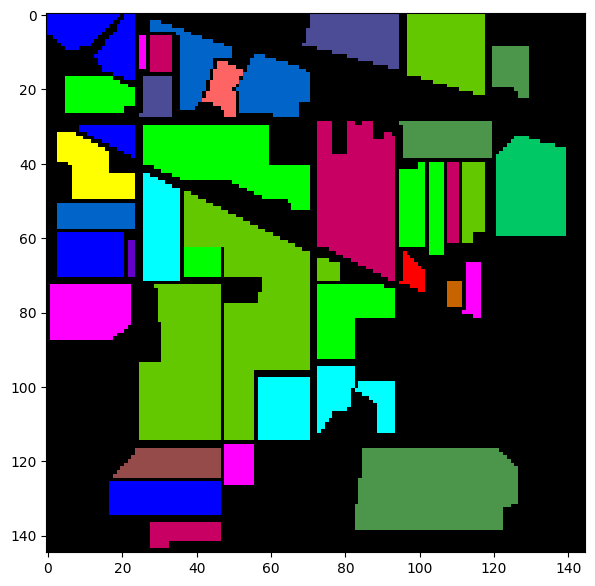

In [45]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

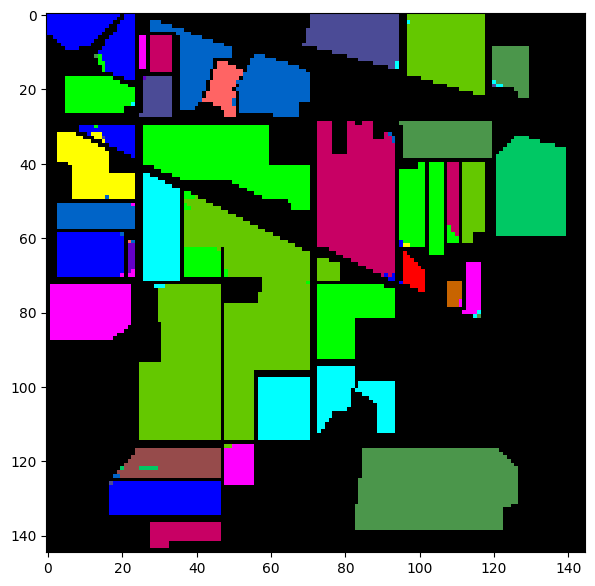

In [46]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [47]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)